# Primary NLP Techniques

In this Module 3 notebook we study the primary NLP techniques that are used for the extraction, analysis and aggregation of insights from large volumes of text.

The techniques are,

1.   Temporal analysis
2.   Word frequency analysis
3.   N-gram analysis
4.   Topic modelling
5.   Keyword extraction
6.   Part-of-speech tagging
7.   Named entity recognition

We will be using the ChaseSupport dataset. This is a dataset of tweets from the official customer support Twitter account of the Chase Bank, USA. 

## Installing Python Libraries



This code block will install the required Python libraries into the Colab environment. When the code block has fully executed, the Python runtime will automatically restart to install and activate the libraries.
This may take some time, and please ignore any messages saying runtime crashed.

In [ ]:
!pip install bertopic
!pip install --upgrade joblib==1.1.0
!pip install pyLDAvis
!pip install openpyxl==3.0.0 #safety for pandas to import Excel files
!pip install git+https://github.com/LIAAD/yake 
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-9ohqn12d
  Running command git clone -q https://github.com/LIAAD/yake /tmp/pip-req-build-9ohqn12d


## Importing Python Libraries



In [ ]:
#libraries for google drive authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#python libraries for data handling and visualization
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import os

# Importing NLTK libraries for text processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import treebank
from collections import Counter
from collections import Counter, defaultdict

#Import sklearn and other AI libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from sklearn.decomposition import NMF
from bertopic import BERTopic
from umap import UMAP


#LDA
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import warnings
import pyLDAvis.gensim_models

#Keyword extraction
import yake
from yake.highlight import TextHighlighter
from IPython.core.display import display, HTML
import spacy


warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Loading data

Load the ChaseSupport dataset from the shared location.


In [ ]:
#authenticate with you google drive credentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# This is the file ID of the data set, this will download the datafile from the shared location
dataset_id = '1GSRFH5VkqtvTrkY-30IShEJmIgrIRjqS'
Customer_support_data = drive.CreateFile({'id':dataset_id})
Customer_support_data.GetContentFile('ChaseSupport.csv')


In [ ]:
chase_support = pd.read_csv(r"ChaseSupport.csv")

In [ ]:
# view the dataset in its original format
display(chase_support)

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,@116016 again? I thought you were taking care ...
1,Fri Dec 01 00:02:48 +0000 2017,.@ChaseSupport I was just on the phone with cu...
2,Fri Dec 01 00:09:36 +0000 2017,@ChaseSupport Thanks
3,Fri Dec 01 00:16:09 +0000 2017,@116016 I would like to thank Chase for ruinin...
4,Fri Dec 01 00:16:45 +0000 2017,@ChaseSupport hello. I have a checking &amp; s...
...,...,...
8352,Wed Oct 25 23:35:16 +0000 2017,@116016 thank you for making our dream a reali...
8353,Wed Oct 25 23:40:16 +0000 2017,Seriously@chase where is my debit and credit c...
8354,Wed Oct 25 23:49:15 +0000 2017,"""@116016 @ChaseSupport please install an ATM ..."
8355,Wed Oct 25 23:58:44 +0000 2017,@116016 has cut off ties with me after reporti...


Remove any empty rows from the dataset. There can be empty rows in the dataframe which are due to errors when extracting the data.

We use the pandas dropna function for this purpose. Additionally, we need to reset the indexes after removing null rows to avoid any inconsistencies.

In [ ]:
chase_support.isna().sum()

datetime    0
tweet       5
dtype: int64

In [ ]:
chase_support[chase_support['tweet'].isna()]

,datetime,tweet
2891,Sat Nov 25 22:47:39 +0000 2017,NaN
3386,Sun Nov 05 07:22:46 +0000 2017,NaN
7253,Wed Nov 15 20:04:20 +0000 2017,NaN
7703,Wed Oct 04 00:47:54 +0000 2017,NaN
7816,Wed Oct 04 19:17:05 +0000 2017,NaN


In [ ]:
chase_support = chase_support.dropna()
chase_support = chase_support.reset_index(drop=True)

In [ ]:
display(chase_support)

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,@116016 again? I thought you were taking care ...
1,Fri Dec 01 00:02:48 +0000 2017,.@ChaseSupport I was just on the phone with cu...
2,Fri Dec 01 00:09:36 +0000 2017,@ChaseSupport Thanks
3,Fri Dec 01 00:16:09 +0000 2017,@116016 I would like to thank Chase for ruinin...
4,Fri Dec 01 00:16:45 +0000 2017,@ChaseSupport hello. I have a checking &amp; s...
...,...,...
8347,Wed Oct 25 23:35:16 +0000 2017,@116016 thank you for making our dream a reali...
8348,Wed Oct 25 23:40:16 +0000 2017,Seriously@chase where is my debit and credit c...
8349,Wed Oct 25 23:49:15 +0000 2017,"""@116016 @ChaseSupport please install an ATM ..."
8350,Wed Oct 25 23:58:44 +0000 2017,@116016 has cut off ties with me after reporti...


# Data Wrangling 

Let's apply the familiar wrangling techniques for preprocessing: 

1.   Convert the texts to lowercase
2.   Remove URLs
3.   Remove punctuations
4.   Remove stopwords
5.   Remove numbers
6.   Lemmatization

In [ ]:
# lowercase
chase_support["tweet"] = chase_support["tweet"].str.lower()
chase_support.head()

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,@116016 again? i thought you were taking care ...
1,Fri Dec 01 00:02:48 +0000 2017,.@chasesupport i was just on the phone with cu...
2,Fri Dec 01 00:09:36 +0000 2017,@chasesupport thanks
3,Fri Dec 01 00:16:09 +0000 2017,@116016 i would like to thank chase for ruinin...
4,Fri Dec 01 00:16:45 +0000 2017,@chasesupport hello. i have a checking &amp; s...


In [ ]:
#remove urls
#s - spaces
#S - non spaces
def remove_urls(text):
  return re.sub(r'http\S+', '', text)

chase_support["tweet"] = chase_support["tweet"].apply(remove_urls)
chase_support.head()

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,@116016 again? i thought you were taking care ...
1,Fri Dec 01 00:02:48 +0000 2017,.@chasesupport i was just on the phone with cu...
2,Fri Dec 01 00:09:36 +0000 2017,@chasesupport thanks
3,Fri Dec 01 00:16:09 +0000 2017,@116016 i would like to thank chase for ruinin...
4,Fri Dec 01 00:16:45 +0000 2017,@chasesupport hello. i have a checking &amp; s...


In [ ]:
#remove punctuations
# \w - A word character is a character a-z, A-Z, 0-9, including _ (underscore).
# \s - spaces between words
# ^  - for nagation
def remove_punctuations(text):
  text_new = re.sub(r"[^\w\s]",'',text)
  return text_new

chase_support["tweet"]  = chase_support["tweet"] .apply(remove_punctuations)
chase_support.head()

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,116016 again i thought you were taking care of...
1,Fri Dec 01 00:02:48 +0000 2017,chasesupport i was just on the phone with cust...
2,Fri Dec 01 00:09:36 +0000 2017,chasesupport thanks
3,Fri Dec 01 00:16:09 +0000 2017,116016 i would like to thank chase for ruining...
4,Fri Dec 01 00:16:45 +0000 2017,chasesupport hello i have a checking amp savin...


In [ ]:
#remove stopwords
# get the list of all stopwords from the library
stopword_list = stopwords.words('english')
# exclude not as a stopword
stopword_list.remove('not')
 
# A function to remove stopwords from a corpus
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stopword_list]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

chase_support["tweet"]  = chase_support["tweet"] .apply(remove_stop_words)

In [ ]:
#remove numbers
def remove_numbers(text):
  text_new = re.sub('\d+', '', text)
  return text_new
chase_support["tweet"]  = chase_support["tweet"] .apply(remove_numbers)

In [ ]:
#lemmatization

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_tweets(corpus):
    pos_tagged_text = nltk.pos_tag(corpus.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

chase_support['tweet'] = chase_support['tweet'].apply(lemmatize_tweets)
chase_support.head()

display(chase_support)

,datetime,tweet
0,Fri Aug 18 02:20:44 +0000 2017,thought take care location
1,Fri Dec 01 00:02:48 +0000 2017,chasesupport phone cust support learn agent se...
2,Fri Dec 01 00:09:36 +0000 2017,chasesupport thanks
3,Fri Dec 01 00:16:09 +0000 2017,would like thank chase ruin th year anniversar...
4,Fri Dec 01 00:16:45 +0000 2017,chasesupport hello check amp saving account wo...
...,...,...
8347,Wed Oct 25 23:35:16 +0000 2017,thank make dream reality grateful first time h...
8348,Wed Oct 25 23:40:16 +0000 2017,seriouslychase debit credit card
8349,Wed Oct 25 23:49:15 +0000 2017,chasesupport please install atm hermiston im d...
8350,Wed Oct 25 23:58:44 +0000 2017,cut tie report fraud account ask reason confid...


# Temporal analysis of ChaseSupport tweets
Temporal analysis (such as volume of tweets over time) provides a baseline for the operational efficiency of the customer service channel. It also provides insights on low-high traffic periods. 

In the ChaseSupport dataset we have a timestamp variable per tweet, which contains both date and time. (e.g. Tue Oct 31 22:19:15 +0000 2017)

## Day of the week
We can use pandas datetime operations to extract different temporal values from this data.

By default, this data is in the text format. First, we need to convert datetime data to pandas datetime format. 

(the "coerce" flag will set invalid parsing results to "nan".)

In [ ]:
chase_support['datetime']  =  pd.to_datetime(chase_support['datetime'], errors='coerce')

Now we have the data in the correct format. Now we can use this to extract information with pandas datetime functionalities.

Also, we can use pandas value_counts method to get count of each value occurrence.

In [ ]:
#getting weekday counts
chase_support['day_of_the_week'] = chase_support['datetime'].dt.day_name()
weekday_frequencies = chase_support['day_of_the_week'].value_counts(sort=False, ascending=True)

# Ordering weekdays from Monday to Sunday
import calendar
weekday_frequencies = pd.DataFrame({'day':weekday_frequencies.index, 'count':weekday_frequencies.values})
idx=(weekday_frequencies['day'].map({v:k for k,v in dict(enumerate(calendar.day_name)).items()}).sort_values().index)
weekday_frequencies = weekday_frequencies.reindex(idx)
print(weekday_frequencies[['day','count']])

         day  count
1     Monday   1146
5    Tuesday   1517
6  Wednesday   1548
4   Thursday   1289
0     Friday   1284
2   Saturday    874
3     Sunday    694


We can plot these values using matplotlib and seaborn libraries.

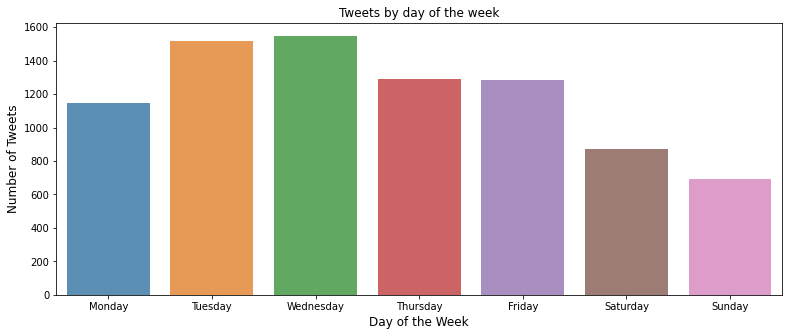

In [ ]:
plt.figure(figsize=(13,5))
sns.barplot(weekday_frequencies['day'], weekday_frequencies['count'], alpha=0.8, )
plt.title('Tweets by day of the week')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
plt.show()

Wednesday and Tuesday are the heaviest traffic which can be useful for staff scheduling or managing traffic via other channels. 

## Hour of the day 

Let's analyse by hour of day. 

Same as day of week, we can extract hour from the datetime variable using pandas.

In [ ]:
chase_support['hour_of_the_day'] = chase_support.datetime.dt.hour.to_list()
hourly_frequencies = chase_support['hour_of_the_day'].value_counts()
hourly_frequencies.sort_index(ascending=True, inplace=True)
print(hourly_frequencies)

0     416
1     391
2     328
3     286
4     218
5     172
6     126
7      82
8      88
9      64
10     69
11    122
12    260
13    336
14    470
15    593
16    564
17    587
18    624
19    592
20    524
21    529
22    477
23    434
Name: hour_of_the_day, dtype: int64


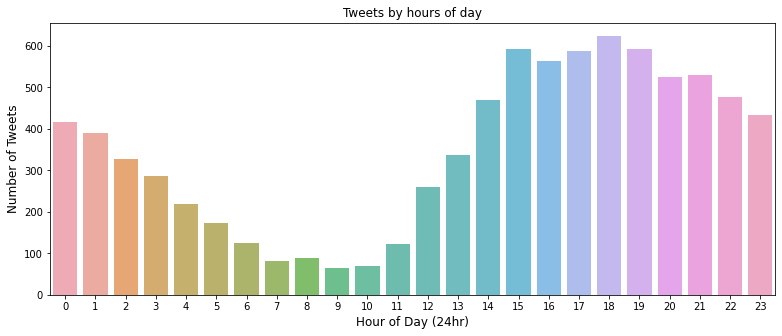

In [ ]:
plt.figure(figsize=(13,5))
sns.barplot(hourly_frequencies.index, hourly_frequencies.values, alpha=0.8)
plt.title('Tweets by hours of day')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Hour of Day (24hr)', fontsize=12)
plt.show()

Here the insight is high traffic from 3pm to 11pm, which is an uneven peak that should ideally settle by 6-7pm. 

## Day of the month

In [ ]:
chase_support['day_of_the_month'] = chase_support.datetime.dt.day.to_list()
daily_frequencies = chase_support['day_of_the_month'].value_counts()
daily_frequencies.sort_index(ascending=True, inplace=True)
print(daily_frequencies)

1     327
2     264
3     269
4     256
5     230
6     300
7     308
8     242
9     293
10    289
11    184
12    212
13    282
14    283
15    231
16    313
17    328
18    266
19    253
20    279
21    302
22    297
23    197
24    232
25    292
26    255
27    359
28    287
29    231
30    314
31    177
Name: day_of_the_month, dtype: int64


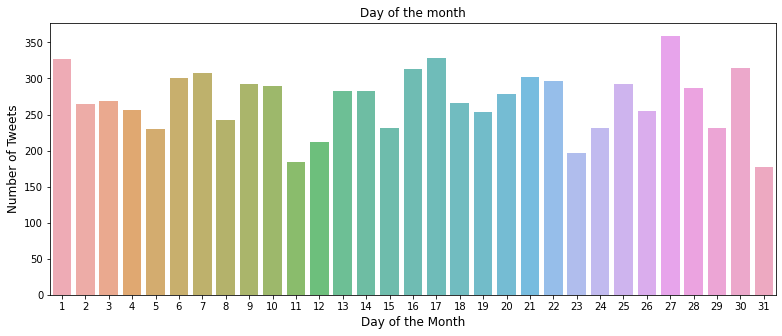

In [ ]:
plt.figure(figsize=(13,5))
sns.barplot(daily_frequencies.index, daily_frequencies.values, alpha=0.8)
plt.title('Day of the month')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Day of the Month', fontsize=12)
plt.show()

# Word Frequency Analysis

Here we look at which words are frequently used within the dataset as a potential representation of issues, concerns expressed during different periods of the year/month. 

In [ ]:
#combining all the tweets.
all_tweets = ' '.join(chase_support['tweet'])
tweet_splits = all_tweets.split()

In [ ]:
# Create a word frequency series. using pandas value_counts
word_frequency = pd.Series(tweet_splits).value_counts()

In [ ]:
#get top 20 words
word_frequency[:20]

chasesupport    3461
chase           1933
card            1649
get             1320
bank            1295
account         1217
not              954
customer         758
im               745
credit           586
go               583
money            560
service          549
use              505
need             502
call             491
help             482
pay              472
dont             471
check            466
dtype: int64

Looking at the top 20, it is obvious that chasesupport and chase would be first and second. However, the remaining words are more informative: card, bank, money, credit, help etc.

### **Word frequency using a bar graph**

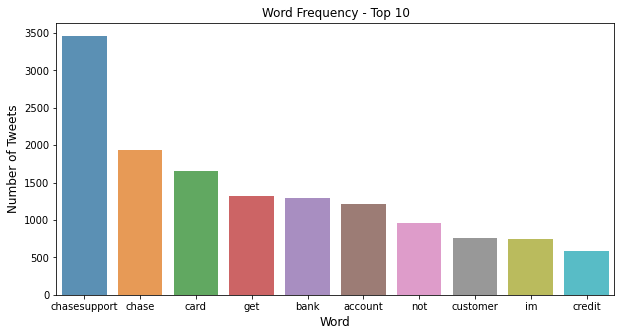

In [ ]:
# Use a bar graph to visualize the top N words  
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Word Frequency - Top 10')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

### **Word frequency using a word cloud**

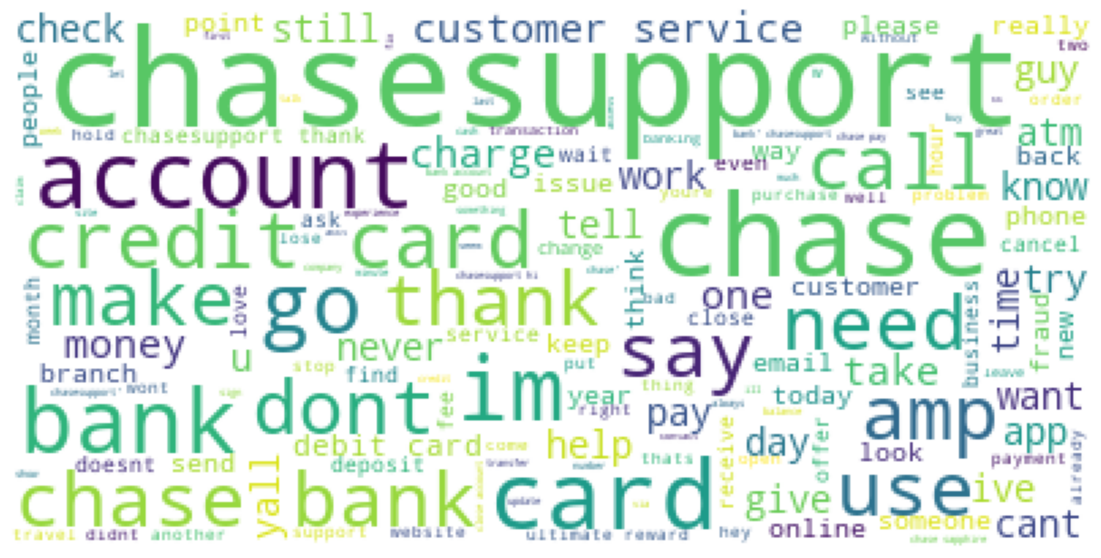

In [ ]:
corpus = list(chase_support["tweet"])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))
plt.figure(figsize=(20,10))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### **Remove known terms**

Let's remove the most common and obvious terms, such as "chasesupport", "chase", "bank".

In [ ]:
# Creating a list of common words

words_to_remove = ["chasesupport", "chase", "bank", "chase bank"]
# A function to remove stopwords from a corpus
def remove_common_words(tweet):
  tokens = tweet.split()
  common_words_removed_tokens = [t for t in tokens if t not in words_to_remove]
  convert_to_string = " ".join(common_words_removed_tokens)
  return convert_to_string

chase_support["tweet"]  = chase_support["tweet"].apply(remove_common_words)

### **Word cloud - second attempt**

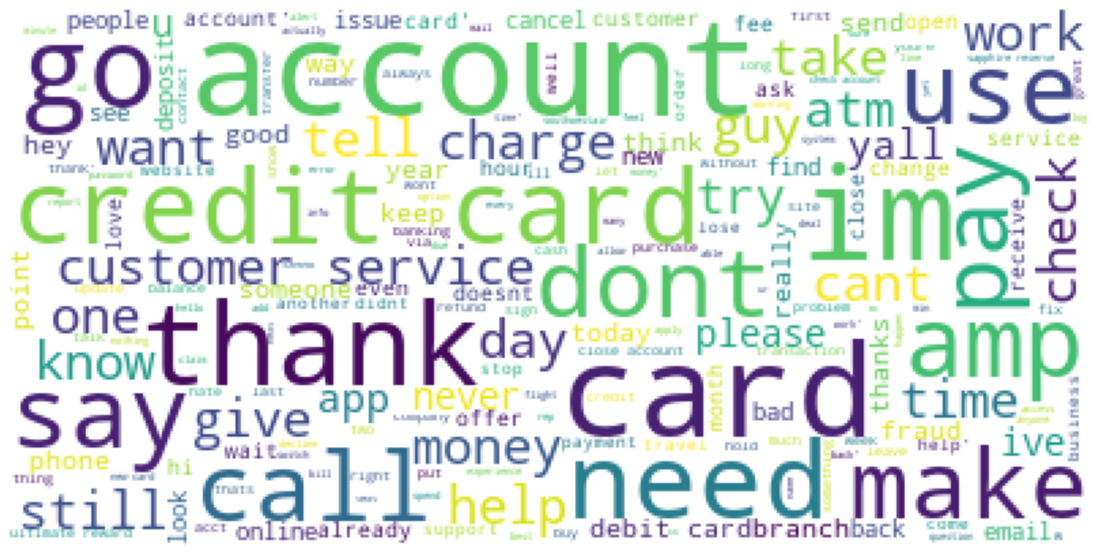

In [ ]:
corpus = list(chase_support["tweet"])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))
plt.figure(figsize=(20,10))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# n-gram Analysis

An n-gram is a continuous sequence of n terms in a given sample of text or speech.  

n-grams where n > 1 are more representative of the meaning compared to uni-grams or words by themselves.  

<img src="http://drive.google.com/uc?export=view&id=1IwuuHYkNFXRDGKSI4Vue-mHyiOMw6hYS" />



Let's start with bi-grams (n=2)

1.   Extract and create a list of unique bigrams.
2.   Create a matrix that contain count of each bigram in each document
3.   Rank bigrams based on the sum of count.

For these steps we will use sklearn CountVectorizer.


[Link to further reading](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  

In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, range):
    
    # Create CountVectorizer object from sklearn library with bi-grams
    term_counts = CountVectorizer(ngram_range=(range, range), max_features=2000).fit(corpus)
    
    # Create BoW feature representation using word frequency
    document_term_matrix = term_counts.transform(corpus)

    # compute sum of words
    sum_words = document_term_matrix.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in term_counts.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

An example to see how this function works. Here n = 4. 

In [ ]:
txts = ['John likes to watch movies', 'Mary likes movies too', 'Mary also likes to watch football games']
get_ngrams(txts, 4)

[('john likes to watch', 1),
 ('likes to watch movies', 1),
 ('mary likes movies too', 1),
 ('mary also likes to', 1),
 ('also likes to watch', 1),
 ('likes to watch football', 1),
 ('to watch football games', 1)]

### **Bigrams (2-gram)**



In [ ]:
bigrams = get_ngrams(chase_support["tweet"].tolist(), range=2)

In [ ]:
# view the bi-grams
bigrams

[('credit card', 407),
 ('customer service', 342),
 ('debit card', 220),
 ('ultimate reward', 112),
 ('close account', 100),
 ('check account', 81),
 ('sapphire reserve', 80),
 ('new card', 74),
 ('im not', 61),
 ('overdraft fee', 59),
 ('mobile app', 55),
 ('take money', 54),
 ('get new', 53),
 ('open account', 52),
 ('please help', 52),
 ('deposit check', 48),
 ('not work', 48),
 ('need help', 47),
 ('every time', 46),
 ('use card', 43),
 ('im go', 39),
 ('direct deposit', 39),
 ('reward point', 39),
 ('card get', 39),
 ('cant get', 37),
 ('get money', 36),
 ('would like', 35),
 ('new debit', 35),
 ('keep get', 35),
 ('saving account', 34),
 ('money account', 34),
 ('book flight', 34),
 ('fraud alert', 34),
 ('dont know', 34),
 ('take care', 33),
 ('sapphire card', 33),
 ('im try', 33),
 ('still not', 33),
 ('customer support', 32),
 ('account number', 32),
 ('let know', 32),
 ('look like', 32),
 ('last night', 31),
 ('money back', 31),
 ('account get', 30),
 ('try get', 30),
 ('phon

In [ ]:
# Convert bigrams to a dataframe with column names bi-gram and frequency.
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bigram", "Freq"]


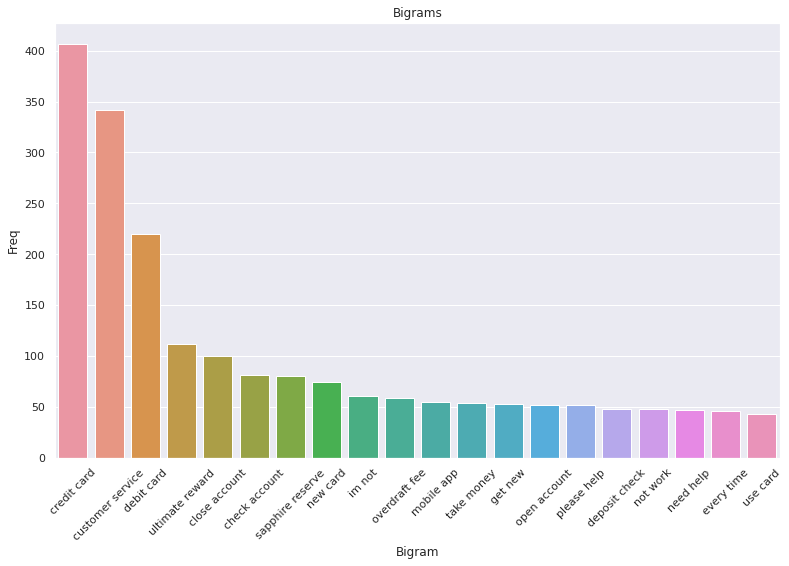

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bigram", y="Freq", data=bigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.title('Bigrams')
plt.show()

A large number of tweets regarding credit cards, twice as much as debit cards. 


### **Trigrams (3-gram)**

Let's explore trigrams. 

In [ ]:
trigrams = get_ngrams(chase_support["tweet"].tolist(), range=3)

Convert tri-grams to a dataframe with column names Trigram and frequency.

In [ ]:
trigrams_df = pd.DataFrame(trigrams)
trigrams_df.columns=["Trigram", "Freq"]

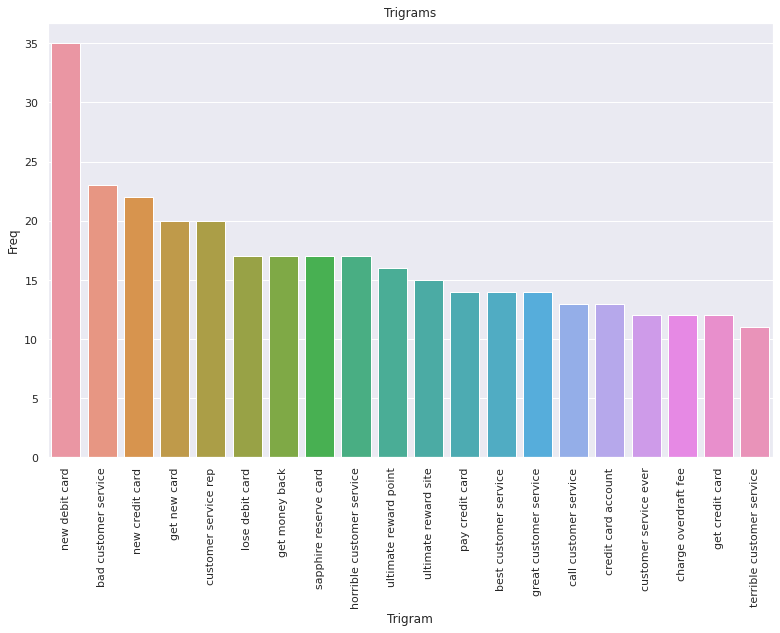

In [ ]:
# Barplot of most freq Trigrams
top_trigrams_to_show = 20
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Trigram", y="Freq", data=trigrams_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Trigrams')
plt.show()

Compared to bigrams, here we have more tweets about "new debit cards". Notice how the trigram is heading towards a noun-verb combo. 

# **Topic modelling**

Topic modelling techniques use probabilistic models to identify abstract topics that occur in a collection of documents. It is an unsupervised learning method based on the assumption that documents contain sequences of words and these sequences determine topics. In contrast, topic classification is a supervised learning method which required a labelled dataset for training an AI model. 

## Non-Negative Matrix Factorization (NMF) 

NMF is a dimensionality reduction method that received a term-document matrix as the input and produces two non-negative matrices of n-words by k-topics and those same k-topics by m-original documents. 

<img src="http://drive.google.com/uc?export=view&id=1bDNcgWMsB3BYGno5ZA8W6l57h3H5cusR" />

We need to vectorise the datset to create the TD matrix. We use the TF-IDF method via the sklearn implementation.

[Link to further reading](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)


In [ ]:
vect = TfidfVectorizer(ngram_range=(2,3), max_features=20000).fit(chase_support['tweet'])
data = vect.fit_transform(chase_support['tweet'])
vect_feature_names = vect.get_feature_names()

In [ ]:
# NMF : Non-negative matrix factorization 
num_topics = 8
nmf = NMF(n_components=num_topics, random_state=42, alpha=.1, l1_ratio=.5,max_iter=10000).fit(data)

### Visualize the extracted topics

In [ ]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vect.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    return pd.DataFrame(word_dict);

n_top_words = 20
print('NMF')
get_nmf_topics(nmf, n_top_words)

NMF


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08
0,customer service,credit card,debit card,bad ever,overdraft fee,close account,ultimate reward,sapphire reserve
1,bad customer service,new credit card,new debit,bad ever life,charge overdraft,dont care,ultimate reward site,reserve card
2,bad customer,new credit,new debit card,ever life,charge overdraft fee,account yall,reward site,sapphire reserve card
3,worst customer service,credit card bill,lose debit card,yall bad ever,charge account,account already,ultimate reward point,sapphire reserve customer
4,worst customer,card bill,lose debit,yall bad,past year,account keep,ultimate reward website,priority pas
5,best customer service,credit card account,get new,please dont,close acct,account smh,reward website,reserve customer
6,best customer,card account,get debit card,literally bad ever,get charge overdraft,local community,reward point,card instead
7,terrible customer service,pay credit,get debit,literally bad,extend overdraft,im close,reward site not,reserve asap
8,terrible customer,pay credit card,send new,im annoy,extend overdraft fee,im close account,site not,annual fee
9,customer service ever,get credit card,send new debit,one bad,fee waive,close account tomorrow,use ultimate,use sapphire reserve


Are the topics intuitive?

Let's try 20 topics

In [ ]:
num_topics = 20
n_top_words = 5
nmf = NMF(n_components=num_topics, random_state=42, alpha=.1, l1_ratio=.5,max_iter=10000).fit(data)
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
get_nmf_topics(nmf, n_top_words)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,customer service,credit card,debit card,bad ever,overdraft fee,close account,ultimate reward,sapphire reserve,need help,check account,new card,thank much,mobile app,cant get,open account,take care,send dm,fraud alert,im not,need new
1,bad customer service,new credit card,new debit,bad ever life,charge overdraft,dont care,ultimate reward site,reserve card,hi need help,new check account,get new,much get,credit journey,direct deposit,send someone,thanks take care,dm question,look like,not even,need new card
2,bad customer,new credit,new debit card,ever life,charge overdraft fee,account yall,reward site,sapphire reserve card,hi need,new check,get new card,much appreciate,absolute garbage,get text,account phone,thanks take,please respond,thank call,im not even,honestly need
3,worst customer service,credit card bill,lose debit,yall bad ever,charge account,account already,ultimate reward point,sapphire reserve customer,charge account,open check account,finally get,thank much appreciate,work mobile app,get good,branch open account,last night,dm help,thank fraud,not understanding,do need
4,worst customer,card bill,lose debit card,yall bad,past year,account keep,ultimate reward website,priority pas,hold minute,open check,card mail,much free good,work mobile,time say,absolutely hate,take care customer,help send,ive purchase,im not understanding,might need


## **Latent Dirichlet Allocation (LDA)**
Latent Dirichlet Allocation (LDA) builds a dictionary of all the words in all documents and use conditional probabilities to group these words into given n topics.

In [ ]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [ ]:
# Convert the tweets to a text corpus.
corpus = list(chase_support['tweet'])

In [ ]:
corpus[:4]

['thought take care location',
 'phone cust support learn agent see digit ssn seem like privacysecurity risk allow s agent kind access',
 'thanks',
 'would like thank ruin th year anniversary nothing like business liers lie cost new account get make plan base word big fat lie mess anniversary plan']

In [ ]:
# Tokenization
tokenized_tweets = [[word for word in str(document).split()] for document in corpus]

In [ ]:
tokenized_tweets[:4]

[['thought', 'take', 'care', 'location'],
 ['phone',
  'cust',
  'support',
  'learn',
  'agent',
  'see',
  'digit',
  'ssn',
  'seem',
  'like',
  'privacysecurity',
  'risk',
  'allow',
  's',
  'agent',
  'kind',
  'access'],
 ['thanks'],
 ['would',
  'like',
  'thank',
  'ruin',
  'th',
  'year',
  'anniversary',
  'nothing',
  'like',
  'business',
  'liers',
  'lie',
  'cost',
  'new',
  'account',
  'get',
  'make',
  'plan',
  'base',
  'word',
  'big',
  'fat',
  'lie',
  'mess',
  'anniversary',
  'plan']]

In [ ]:
# Create a dictionary based on the tokenized words of all the tweets.
dictionary = corpora.Dictionary(tokenized_tweets)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'chase.dict'))

When creating the dictionary, each tweet is alphabetically sorted before composing the dictionary.

In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'care': 0, 'location': 1, 'take': 2, 'thought': 3, 'access': 4, 'agent': 5, 'allow': 6, 'cust': 7, 'digit': 8, 'kind': 9, 'learn': 10, 'like': 11, 'phone': 12, 'privacysecurity': 13, 'risk': 14, 's': 15, 'see': 16, 'seem': 17, 'ssn': 18, 'support': 19, 'thanks': 20, 'account': 21, 'anniversary': 22, 'base': 23, 'big': 24, 'business': 25, 'cost': 26, 'fat': 27, 'get': 28, 'lie': 29, 'liers': 30, 'make': 31, 'mess': 32, 'new': 33, 'nothing': 34, 'plan': 35, 'ruin': 36, 'th': 37, 'thank': 38, 'word': 39, 'would': 40, 'year': 41, 'amp': 42, 'check': 43, 'convert': 44, 'dollar': 45, 'hello': 46, 'london': 47, 'possible': 48, 'pound': 49, 'saving': 50, 'travel': 51, 'week': 52, 'wonder': 53, 'airline': 54, 'bad': 55, 'cancel': 56, 'card': 57, 'crappy': 58, 'credit': 59, 'perk': 60, 'southwest': 61, 'southwestair': 62, 'stop': 63, 'thing': 64, 'wasteofloyalty': 65, 'caller': 66, 'hang': 67, 'set': 68, 'add': 69, 'approach': 70, 'change': 71, 'im': 72, 'password': 73, 'platform': 74, 'space':

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in tokenized_tweets]

Can you explain this output?

In [ ]:
tweet_id = 100
print(tokenized_tweets[tweet_id]) # each tweet converted to tokens
print(corpus[tweet_id]) # each token is represented as a id from a dictionary

['husband', 'think', 'cancel', 'account']
[(21, 1), (56, 1), (432, 1), (557, 1)]


### **Generate a topic model**




In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus] 

In [ ]:
print(corpus_tfidf[tweet_id])

[(21, 0.2390378263659048), (56, 0.4597873091787841), (432, 0.4465481696154394), (557, 0.7294184533568489)]


We need to define the number of topics for the LDA algorithm.

In [ ]:
total_topics = 10

The following commands build the LDA topic model.   
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics, alpha=0.6)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

The above LDA model is built with 10 topics where each topic is a combination of keywords and each keyword contributes a certain weight to the topic.  
You can see the keywords for each topic and the weight(importance) of each keyword using lda_model.print_topics() as shown next.


In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.025*"customer" + 0.025*"go" + 0.023*"service" + 0.016*"atm" + 0.014*"not" + 0.013*"fee"'),
 (1,
  '0.015*"account" + 0.014*"want" + 0.013*"good" + 0.012*"make" + 0.012*"im" + 0.010*"point"'),
 (2,
  '0.018*"pay" + 0.011*"day" + 0.009*"make" + 0.009*"help" + 0.008*"flight" + 0.008*"customer"'),
 (3,
  '0.015*"card" + 0.013*"n" + 0.010*"close" + 0.010*"account" + 0.009*"im" + 0.009*"get"'),
 (4,
  '0.033*"get" + 0.033*"card" + 0.018*"use" + 0.011*"account" + 0.010*"back" + 0.010*"need"'),
 (5,
  '0.071*"account" + 0.018*"check" + 0.012*"please" + 0.012*"get" + 0.011*"one" + 0.011*"close"'),
 (6,
  '0.032*"get" + 0.018*"help" + 0.015*"im" + 0.015*"charge" + 0.015*"card" + 0.015*"cant"'),
 (7,
  '0.018*"money" + 0.014*"not" + 0.010*"account" + 0.010*"like" + 0.010*"get" + 0.009*"customer"'),
 (8,
  '0.025*"app" + 0.015*"pay" + 0.015*"not" + 0.012*"get" + 0.012*"thank" + 0.010*"work"'),
 (9,
  '0.081*"card" + 0.037*"credit" + 0.020*"get" + 0.019*"new" + 0.013*"im" + 0.013*"today"'

### **LDA visual topic explorer**

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  12.280066
7       0.648955  71.707100       2        1  10.824352
6      71.019684   9.971006       3        1  10.347435
1       3.785981  33.185135       4        1  10.320854
0     -42.666500  -9.222070       5        1  10.027036
2      -3.621689 -43.526516       6        1   9.943743
3      -3.632402  -4.171708       7        1   9.150935
9     -36.584400  35.804413       8        1   9.112153
4      44.391380  50.615383       9        1   9.048740
5      40.235809 -31.591665      10        1   8.944687, topic_info=        Term        Freq       Total Category  logprob  loglift
57      card  141.000000  141.000000  Default  30.0000  30.0000
21   account  122.000000  122.000000  Default  29.0000  29.0000
59    credit   50.000000   50.000000  Default  28.0000  28.0000
126      app   43.000000   43.000000  Default  27.0000  27.0000
28       get  123.000000  123.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
20    thanks    4.044573   34.081639  Topic10  -5.2188   0.2827
57      card    5.810092  141.990933  Topic10  -4.8565  -0.7821
266    money    4.655313   65.451745  Topic10  -5.0781  -0.2292
11      like    3.781931   39.817465  Topic10  -5.2859   0.0600
42       amp    3.756958   37.309167  Topic10  -5.2925   0.1185

[712 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4         1  0.092754  access
4         2  0.463769  access
4         3  0.092754  access
4         8  0.092754  access
4        10  0.092754  access
...     ...       ...     ...
133       9  0.114003     yet
133      10  0.114003     yet
2333      5  0.772975    youd
2051      6  0.551799   youll
2780      5  0.815583   zelle

[1478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 7, 2, 1, 3, 4, 10, 5, 6])

## **BERTopic**

BERTopic is a more recent method that utilizes state-of-the-art language models and clustering methods to extract the topics. BERTopic supports several visualizations to express the topics.

[Link to further reading](https://maartengr.github.io/BERTopic/index.html)

Due to stochasticity of the techniques used in BERTopic, you may not receive the same results as those shown in this notebook instance.


In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=17)
model = BERTopic(umap_model=umap_model,verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7,diversity=0.2)
headline_topics, _ = model.fit_transform(chase_support['tweet'])


Batches:   0%|          | 0/261 [00:00<?, ?it/s]

2022-11-08 10:27:38,906 - BERTopic - Transformed documents to Embeddings
2022-11-08 10:28:32,608 - BERTopic - Reduced dimensionality
2022-11-08 10:28:33,021 - BERTopic - Clustered reduced embeddings


BERTopic is quite advanced that we do not have to provide a N number of topics, which it automatically decides the optimal.

In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq

Number of topics: 165


,Topic,Count,Name
0,-1,3176,-1_account_customer_card_call
1,0,250,0_debit_card_lose_hasnt
2,1,233,1_flight_travel_ticket_airline
3,2,203,2_deposit_check_pic_app
4,3,199,3_sapphire_sapphirereserve_travel_priority
...,...,...,...
160,159,7,159_chasebank_arthurave_warrenville_homeschool
161,160,7,160_atm_deposit_beeping_itsnot
162,161,7,161_log_login_pssw_usernamepassword
163,162,7,162_signature_electronically_baffles_digitalpa...


We can expand a given topic as below.

In [ ]:
a_topic = freq.iloc[4]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('sapphire', 0.10427342460645339),
 ('sapphirereserve', 0.016930447022565968),
 ('travel', 0.01614588353237002),
 ('priority', 0.015678961082501996),
 ('lounge', 0.013835063139385267),
 ('card', 0.011796257401606525),
 ('insurance', 0.011148441579975724),
 ('bonus', 0.007087945218700013),
 ('price', 0.006565192227086569),
 ('delay', 0.006481171488648456)]

With BERTopic we can draw bar charts for a given subset of topics. Let's select some good topics and draw bar some charts

In [ ]:
model.visualize_barchart(topics=[1,2,3,4])

In addition to the bar charts BERTopic has the intertopic distance map visualization.

In [ ]:
model.visualize_topics()

Another useful feature in BERTopic is the capability to search topics.

In [ ]:
# Select 3 most similar topics to "debit"
similar_topics, similarity = model.find_topics("debit", top_n = 3)
print(similar_topics)

[0, 4, 82]


In [ ]:
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('debit', 0.05455120780748533), ('card', 0.02952051545417828), ('lose', 0.021574111549715183), ('hasnt', 0.008760073189555469), ('temp', 0.00861531178858297), ('ud', 0.007531959930521544), ('mail', 0.0073154554353345265), ('cancel', 0.007200284801885715), ('overnight', 0.006638110867162875), ('printing', 0.005896793743493989)]
Similarity Score: 0.7901902243410075


# **Keyword Extraction**

Keyword extraction (also known as keyword detection or keyword analysis) is an NLP technique that automatically extracts the most significant words and expressions. 

[YAKE](https://github.com/LIAAD/yake) is the state of the art for keyword extraction. The preprocessing pipeline is different compared to other techniques. No uncasing or stop word removal is needed since the YAKE algorithm manages this internally.

Let's define extract_kwrds as the function for extracting keywords from a given text. 


### **Yake keyword extraction - functions**

In [ ]:
def extract_kwrds(text,numOfKeywords = 30):
  language = "en"
  max_ngram_size = 3
  deduplication_thresold = 0.9
  deduplication_algo = 'seqm'
  windowSize = 1
  kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
  return kw_extractor.extract_keywords(text)

### **Yake keyword extraction - sample text**




In [ ]:
text = "Sources tell us that Google is acquiring Kaggle, a platform that hosts data science and machine learning "\
"competitions. Details about the transaction remain somewhat vague, but given that Google is hosting its Cloud "\
"Next conference in San Francisco this week, the official announcement could come as early as tomorrow. "\
"Reached by phone, Kaggle co-founder CEO Anthony Goldbloom declined to deny that the acquisition is happening. "\
"Google itself declined 'to comment on rumors'. Kaggle, which has about half a million data scientists on its platform, "\
"was founded by Goldbloom  and Ben Hamner in 2010. "\
"The service got an early start and even though it has a few competitors like DrivenData, TopCoder and HackerRank, "\
"it has managed to stay well ahead of them by focusing on its specific niche. "\
"The service is basically the de facto home for running data science and machine learning competitions. "\
"With Kaggle, Google is buying one of the largest and most active communities for data scientists - and with that, "\
"it will get increased mindshare in this community, too (though it already has plenty of that thanks to Tensorflow "\
"and other projects). Kaggle has a bit of a history with Google, too, but that's pretty recent. Earlier this month, "\
"Google and Kaggle teamed up to host a $100,000 machine learning competition around classifying YouTube videos. "\
"That competition had some deep integrations with the Google Cloud Platform, too. Our understanding is that Google "\
"will keep the service running - likely under its current name. While the acquisition is probably more about "\
"Kaggle's community than technology, Kaggle did build some interesting tools for hosting its competition "\
"and 'kernels', too. On Kaggle, kernels are basically the source code for analyzing data sets and developers can "\
"share this code on the platform (the company previously called them 'scripts'). "\
"Like similar competition-centric sites, Kaggle also runs a job board, too. It's unclear what Google will do with "\
"that part of the service. According to Crunchbase, Kaggle raised $12.5 million (though PitchBook says it's $12.75) "\
"since its   launch in 2010. Investors in Kaggle include Index Ventures, SV Angel, Max Levchin, Naval Ravikant, "\
"Google chief economist Hal Varian, Khosla Ventures and Yuri Milner "

In [ ]:
keywords = extract_kwrds(text,20)
print(keywords)

[('Google', 0.026580863364597897), ('Kaggle', 0.0289005976239829), ('CEO Anthony Goldbloom', 0.029946071606210194), ('San Francisco', 0.048810837074825336), ('Anthony Goldbloom declined', 0.06176910090701819), ('Google Cloud Platform', 0.06261974476422487), ('co-founder CEO Anthony', 0.07357749587020043), ('acquiring Kaggle', 0.08723571551039863), ('CEO Anthony', 0.08915156857226395), ('Anthony Goldbloom', 0.09123482372372106), ('machine learning', 0.09147989238151344), ('Kaggle co-founder CEO', 0.093805063905847), ('data', 0.097574333771058), ('Google Cloud', 0.10260128641464673), ('machine learning competitions', 0.10773000650607861), ('Francisco this week', 0.11519915079240485), ('platform', 0.1183512305596321), ('conference in San', 0.12392066376108138), ('service', 0.12546743261462942), ('Goldbloom', 0.14611408778815776)]


Let's highlight these keywords in the News article itself. 

In [ ]:
# Keyword Highlighter
th = TextHighlighter(max_ngram_size = 3, highlight_pre = '<span style="background-color: yellow;">', highlight_post= "</span>")
highlight = th.highlight(text,keywords)
display(HTML(highlight))

# Part-of-speech tagging



<img src="http://drive.google.com/uc?export=view&id=1nJuIs5hNQCH7QZ8PAN0lVH6jDux29N-z" width="700px"/>


Part-of-speech tagging relates to syntactics where we categorise each word into its syntactic meaning, such as noun, verb, adjective etc. There are several tools for POS tagging. Here we will be using spacy library.
    

**Spacy POS Tags List**

Every token is assigned a POS Tag in Spacy from the following list:

<table>
 <tr>
    <th>POS</th>
    <th>DESCRIPTION</th>
    <th>EXAMPLES</th>
  </tr>

<tr><td>ADJ	  </td><td>  adjective</td><td>	    *big, old, green, incomprehensible, first*
<tr><td>ADP</td><td>	    adposition</td><td>	  *in, to, during*
<tr><td>ADV</td><td>	    adverb</td><td>	      *very, tomorrow, down, where, there*
<tr><td>AUX</td><td>	    auxiliary</td><td>	*is, has (done), will (do), should (do)*
<tr><td>CONJ	 </td><td> conjunction</td><td>	*and, or, but*
<tr><td>CCONJ	  </td><td>coordinating conjunction</td><td>	*and, or, but*
<tr><td>DET	  </td><td>  determiner</td><td>	*a, an, the*
<tr><td>INTJ	 </td><td> interjection</td><td>	*psst, ouch, bravo, hello*
<tr><td>NOUN	  </td><td>noun</td><td>	*girl, cat, tree, air, beauty*
<tr><td>NUM	    </td><td>numeral</td><td>	*1, 2017, one, seventy-seven, IV, MMXIV*
<tr><td>PART	</td><td>  particle</td><td>	*’s, not,*
<tr><td>PRON	 </td><td> pronoun</td><td>	*I, you, he, she, myself, themselves, somebody*
<tr><td>PROPN	</td><td>  proper noun</td><td>	*Mary, John, London, NATO, HBO*
<tr><td>PUNCT	 </td><td> punctuation</td><td>	*., (, ), ?*
<tr><td>SCONJ</td><td>	  subordinating conjunction</td><td>	*if, while, that*
<tr><td>SYM	 </td><td>   symbol</td><td>	*$, %, §, ©, +, −, ×, ÷, =, :), 😝*
<tr><td>VERB	</td><td>  verb</td><td>	*run, runs, running, eat, ate, eating*
<tr><td>X	   </td><td>   other</td><td>	*sfpksdpsxmsa*
<tr><td>SPACE	   </td><td>   space</td><td>
</table>


[Link to further reading](https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/)


### Example usage of POS tagging
See following example of POS tagging for the sentence "SpaceX was founded in 2002 by Elon Musk with the goal of reducing space transportation costs to enable the colonization of Mars." 



In [ ]:
# Load the en_core_web_sm model
nlp = spacy.load("en_core_web_sm")
#building spacy document
doc = nlp("SpaceX was founded in 2002 by Elon Musk with the goal of reducing space transportation costs to enable the colonization of Mars.")

#showing POS tag per each word with explaination
print(f"{'text':{15}} {'POS':{8}} {'POS explained':{20}} \n")
for token in doc:
  print(f'{token.text:{15}} {token.pos_:{8}}  {spacy.explain(token.pos_):{20}}')

text            POS      POS explained        

SpaceX          PROPN     proper noun         
was             AUX       auxiliary           
founded         VERB      verb                
in              ADP       adposition          
2002            NUM       numeral             
by              ADP       adposition          
Elon            PROPN     proper noun         
Musk            PROPN     proper noun         
with            ADP       adposition          
the             DET       determiner          
goal            NOUN      noun                
of              ADP       adposition          
reducing        VERB      verb                
space           NOUN      noun                
transportation  NOUN      noun                
costs           NOUN      noun                
to              PART      particle            
enable          VERB      verb                
the             DET       determiner          
colonization    NOUN      noun                
of          

### Applying POS on our dataset
We determine POS for each tweet. Then we summarize the results to see what are the different POS tags being used in the entire dataset.

In [ ]:
#writing a function to extract POS tags
def POS_tagging(tweet):
  #convert tweet into spacy document
  doc = nlp(tweet)
  #extract POS tags
  pos = [(token.text, token.pos_) for token in doc]
  return pos

data = (' ').join(chase_support['tweet'])
tagged_sents = POS_tagging(data)

corpus_counts = defaultdict(Counter)
for word, pos in tagged_sents:
    corpus_counts[pos][word] +=1


Let's see what are the adjectives used in the dataset.

In [ ]:
print(corpus_counts['ADJ'])
print(corpus_counts['NOUN'])

Counter({'new': 373, 'bad': 223, 'close': 209, 'open': 197, 'good': 189, 'last': 141, 'online': 111, 'ultimate': 102, 'great': 95, 'able': 89, 'best': 88, 'first': 79, 'due': 79, 'fraudulent': 77, 'much': 75, 'right': 72, 'happy': 71, 'many': 71, 'mobile': 71, 'long': 71, 'sure': 67, 'ill': 62, 'horrible': 62, 'clear': 60, 'next': 59, 'terrible': 59, 'available': 58, 'nice': 58, 'direct': 57, 'quick': 57, 'ridiculous': 54, 'enough': 54, 'different': 53, 'late': 52, 'free': 51, 'full': 51, 'wrong': 49, 'worst': 49, 'possible': 48, 'real': 46, 'poor': 45, 'big': 43, 'old': 43, 'local': 42, 'second': 42, 'secure': 41, 'helpful': 39, 'awesome': 37, 'multiple': 37, 'stupid': 36, 'worth': 36, 'personal': 35, 'portal': 34, 'little': 32, 'amp': 32, 'unable': 32, 'sad': 31, 'negative': 30, 'low': 30, 'fine': 30, 'hard': 30, 'annual': 29, 'actual': 29, 'awful': 28, 'high': 27, 'loyal': 27, 'ready': 26, 'extra': 26, 'foreign': 25, 'several': 25, 'least': 24, 'damn': 24, 'single': 24, 'easy': 24, 

# Named Entity Recognition

### Understanding Named Entity Recognition

<img src="http://drive.google.com/uc?export=view&id=1xi2TWrDBUEaM7M5sws2d-VuJzqGolsc4" width="700px" />


Named entity recognition (NER)  identifies and classifies named entities into predefined categories, such as person, organization, country, and etc.


In this exercise, we will identify and classify the labels of various named entities in a body of text using one of spaCy's statistical models. Following is a list of Named entities in spacy.

<table>
 <tr>
    <th>NER</th>
    <th>DESCRIPTION</th>
 
  </tr>
<tr><td>PERSON</td><td> People, including fictional
<tr><td>NORP</td><td> Nationalities or religious or political groups
<tr><td>FACILITY</td><td> Buildings, airports, highways, bridges, etc.
<tr><td>ORGANIZATION</td><td> Companies, agencies, institutions, etc.
<tr><td>GPE</td><td> Countries, cities, states
<tr><td>LOCATION</td><td> Non-GPE locations, mountain ranges, bodies of water
<tr><td>PRODUCT</td><td> Vehicles, weapons, foods, etc. (Not services)
<tr><td>EVENT</td><td> Named hurricanes, battles, wars, sports events, etc.
<tr><td>WORK OF ART</td><td> Titles of books, songs, etc.
<tr><td>LAW</td><td> Named documents made into laws
<tr><td>LANGUAGE</td><td> Any named language
<tr><td>DATE</td><td> Absolute or relative dates or periods
<tr><td>TIME</td><td> Times smaller than a day
<tr><td>PERCENT</td><td> Percentage (including “%”)
<tr><td>MONEY</td><td> Monetary values, including unit
<tr><td>QUANTITY</td><td> Measurements, as of weight or distance
<tr><td>ORDINAL</td><td> “first”, “second”
<tr><td>CARDINAL</td><td> Numerals that do not fall under another type 

</table>


[Source]  (https://catalog.ldc.upenn.edu/docs/LDC2013T19/OntoNotes-Release-5.0.pdf)


### NER Example 
See following example of NER for the sentence "Sundar Pichai is the CEO of Google. Its headquarters is in Mountain View." 

In [ ]:
import spacy

# Load the en_core_web_sm model
nlp = spacy.load("en_core_web_sm")
# Create a Doc instance
text = 'Sundar Pichai is the CEO of Google. Its headquarter is in Mountain View.'

doc = nlp(text)

# Print all named entities and their labels
for ent in doc.ents:
    print(ent.text, ent.label_)

Sundar Pichai PERSON
Google ORG
Mountain View GPE


### Applying NER on our dataset

Similar to POS tagging we will tag NER in all the tweets and aggregate the results.

In [ ]:
#to extract Named Entities
def NER_tagging(tweet):
  #convert tweet into spacy document
  doc = nlp(tweet)
  #extract POS tags
  ner = [(ent.text, ent.label_) for ent in doc.ents]
  return ner


data = (' ').join(chase_support['tweet'])
tagged_sents = NER_tagging(data)
import nltk
from nltk.corpus import treebank
from collections import Counter
from collections import Counter, defaultdict
corpus_counts = defaultdict(Counter)
for word, ne in tagged_sents:
    corpus_counts[ne][word] +=1



In [ ]:
print("TIME :",corpus_counts['TIME'])
print("MONEY :",corpus_counts['MONEY'])
print("GPE :",corpus_counts['GPE'])
print("DATE :",corpus_counts['DATE'])
print("PERSON :",corpus_counts['PERSON'])

TIME : Counter({'morning': 47, 'last night': 29, 'tonight': 28, 'hour': 26, 'overnight': 8, 'last minute': 6, 'two hour': 5, 'night': 5, 'past hour': 4, 'almost hour': 4, 'less hour': 3, 'nearly hour': 2, 'last hour': 2, 'next hour': 2, 'today hour': 2, 'earlier today': 2, 'another hour': 2, 'afternoon': 2, 'several minute': 2, 'early morning': 2, 'deliver hour': 1, 'area pm': 1, 'w minute': 1, 'hold hour': 1, 'close hour': 1, 'hollywood portland morning': 1, 'extra hour': 1, 'three hour': 1, 'afternoon holiday hour': 1, 'joy morning': 1, 'evening': 1, 'annual night': 1, 'fax hour': 1, 'late night': 1, 'saturday hour': 1, 'five minute': 1, 'post hour': 1, 'couple hour': 1, 'half hour ago': 1, 'last night call morning': 1, 'password hour': 1, 'walk minute': 1, 'hour hour': 1, 'one night': 1, 'nearly half hour': 1, 'prior hour': 1, 'almost hour ago': 1, 'midday': 1, 'middle night': 1, 'today come hour': 1, 'close pm': 1, 'four hour': 1, 'every morning': 1, 'three minute ago': 1, 'call ho

---------------------
End of OptusU_AIN_Module3_PrimaryNLP.ipynb
